Optimal x-shift: 0.369 ns
Final chi-squared: 1.51328e-08
Optimal x-shift: 0.390 ns
Final chi-squared: 1.18842e-08
Optimal x-shift: -0.474 ns
Final chi-squared: 2.14456e-08
Optimal x-shift: 0.449 ns
Final chi-squared: 9.31108e-09
Optimal x-shift: 0.490 ns
Final chi-squared: 1.26496e-08
Optimal x-shift: -0.234 ns
Final chi-squared: 1.91736e-08
Optimal x-shift: 0.521 ns
Final chi-squared: 1.63353e-08
Optimal x-shift: -0.053 ns
Final chi-squared: 1.986e-08
Optimal x-shift: 0.027 ns
Final chi-squared: 5.95271e-09
Optimal x-shift: 0.112 ns
Final chi-squared: 1.12951e-08
Optimal x-shift: 0.208 ns
Final chi-squared: 1.03658e-08
Optimal x-shift: 0.282 ns
Final chi-squared: 8.80222e-09
Optimal x-shift: 0.307 ns
Final chi-squared: 9.95494e-09
Optimal x-shift: 0.739 ns
Final chi-squared: 1.39419e-07
Optimal x-shift: 0.307 ns
Final chi-squared: 1.16036e-08
Optimal x-shift: 0.300 ns
Final chi-squared: 1.36443e-08
Optimal x-shift: 0.299 ns
Final chi-squared: 9.14657e-09
Optimal x-shift: -0.711 ns
Fin

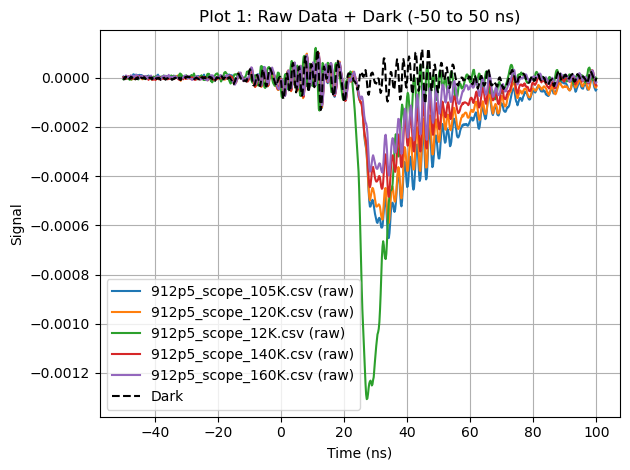

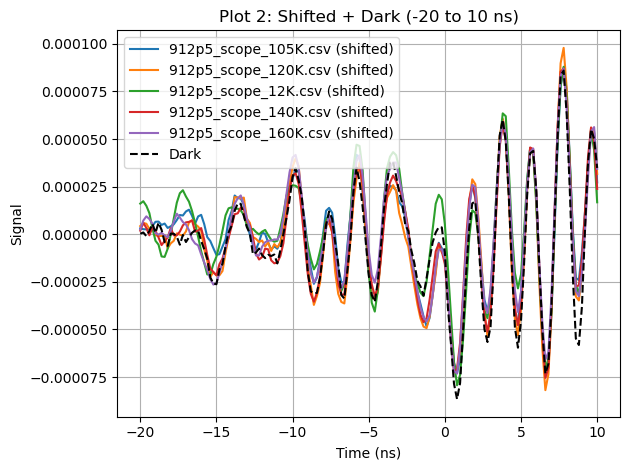

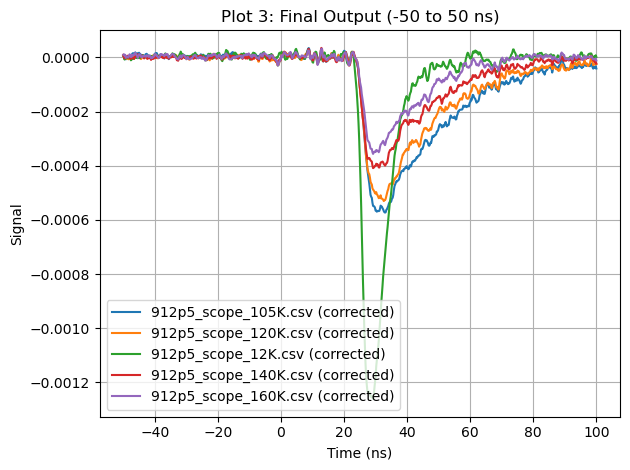

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# ==== USER INPUTS ====
main_folder = r'Z:\Jacob\Material CrPS4\Undoped\04242025 fast dynamics scope and polarization\VTTRPL'
dark_filename = 'dark_scope.csv'
time_column = 0  # Index of time column
data_column = 1  # Index of data column
time_range_ns = (-20, 10)  # X range for alignment (in ns)
max_shift_ns = 1.5  # Maximum x-shift in ns
rows_to_skip = 14  # Number of rows to skip at the top of each file
output_folder = os.path.join(main_folder, 'output')
plot1_range = (-50, 100)  # ns range for Plot 1
dark_points = 50 # number of bins to average to subtract baseline starting from the first bin
# ======================

os.makedirs(output_folder, exist_ok=True)

def load_csv(filepath):
    df = pd.read_csv(filepath, header=None, skiprows=rows_to_skip)
    average_baseline = df.iloc[0:dark_points, data_column].mean()
    df.iloc[:,data_column] -= average_baseline #subtract baseline using initial dark bins
    df.iloc[:, time_column] *= 1e9  # Convert time from seconds to nanoseconds
    return df

def extract_range(data, t_col, d_col, tmin, tmax):
    x = data.iloc[:, t_col]
    y = data.iloc[:, d_col]
    mask = (x >= tmin) & (x <= tmax)
    return x[mask].to_numpy(), y[mask].to_numpy()

def align_dark(data_time, data_signal, dark_data, x_range, shift_limit_ns):
    """Aligns dark to data by finding optimal x-shift within shift_limit_ns."""
    # Extract dark in the same x-range
    dark_time_range, dark_signal_range = extract_range(dark_data, time_column, data_column, *x_range)

    # Center signals
    data_signal_centered = data_signal# - np.mean(data_signal)
    dark_signal_centered = dark_signal_range# - np.mean(dark_signal_range)

    # Interpolated dark function
    interp_dark = interp1d(dark_time_range, dark_signal_centered, kind='linear', fill_value='extrapolate')

    # Define least squares error function
    def error(shift):
        shifted_time = data_time - shift
        diff = data_signal_centered - interp_dark(shifted_time)
        return np.sum(diff**2)

    # Minimize error over shift range
    shift_bounds = (-shift_limit_ns, shift_limit_ns)  # ns
    res = minimize_scalar(error, bounds=shift_bounds, method='bounded')

    optimal_shift = res.x
    final_chi_squared = res.fun

    # 🖨️ Print results
    print(f"Optimal x-shift: {optimal_shift:.3f} ns")
    print(f"Final chi-squared: {final_chi_squared:.6g}")

    # Shift the dark signal full range
    shifted_dark_time = dark_data.iloc[:, time_column] - optimal_shift
    shifted_dark_signal = np.interp(data_time, shifted_dark_time, dark_data.iloc[:, data_column], left=np.nan, right=np.nan)

    return shifted_dark_signal, optimal_shift, final_chi_squared

def interpolate_shifted(data, shift):
    time = data.iloc[:, time_column].to_numpy()
    signal = data.iloc[:, data_column].to_numpy()
    interp = interp1d(time - shift, signal, kind='linear', fill_value='extrapolate')
    shifted_signal = interp(time)
    return pd.DataFrame({0: time, 1: shifted_signal})

def subtract_dark(shifted_data, dark_interp):
    time = shifted_data.iloc[:, 0]
    signal = shifted_data.iloc[:, 1]
    corrected_signal = signal - dark_interp(time)
    return pd.DataFrame({0: time, 1: corrected_signal})

# Load dark data
dark_data = load_csv(os.path.join(main_folder, dark_filename))

# Create interpolator for full dark (no shift)
interp_dark_full = interp1d(dark_data.iloc[:, time_column], dark_data.iloc[:, data_column],
                            kind='linear', fill_value='extrapolate')

# Set up plots
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

# Process each data file
processed_count = 0
for filename in os.listdir(main_folder):
    if not filename.endswith('.csv') or filename == dark_filename:
        continue

    data_path = os.path.join(main_folder, filename)
    data = load_csv(data_path)

    # Crop data for alignment
    data_time_range, data_signal_range = extract_range(data, time_column, data_column, *time_range_ns)

    # Align dark
    shifted_dark_signal, optimal_shift, final_chi_squared = align_dark(
        data_time_range, data_signal_range,
        dark_data,  # << pass full dark_data
        time_range_ns, max_shift_ns
    )

    # Shift data itself
    shifted_data = interpolate_shifted(data, optimal_shift)

    # Subtract dark (using *non-shifted* dark interpolator)
    corrected_data = subtract_dark(shifted_data, interp_dark_full)

    # Save corrected data
    output_path = os.path.join(output_folder, filename)
    corrected_data.to_csv(output_path, index=False, header=False)

    if processed_count < 5:
        # Plot 1: Raw data
        raw_mask = (data.iloc[:, time_column] >= plot1_range[0]) & (data.iloc[:, time_column] <= plot1_range[1])
        ax1.plot(data.iloc[:, time_column][raw_mask], data.iloc[:, data_column][raw_mask], label=f'{filename} (raw)')

        # Plot 2: Shifted (before subtracting)
        shift_mask = (shifted_data.iloc[:, 0] >= time_range_ns[0]) & (shifted_data.iloc[:, 0] <= time_range_ns[1])
        ax2.plot(shifted_data.iloc[:, 0][shift_mask], shifted_data.iloc[:, 1][shift_mask], label=f'{filename} (shifted)')

        # Plot 3: Final output
        final_mask = (corrected_data.iloc[:, 0] >= plot1_range[0]) & (corrected_data.iloc[:, 0] <= plot1_range[1])
        ax3.plot(corrected_data.iloc[:, 0][final_mask], corrected_data.iloc[:, 1][final_mask], label=f'{filename} (corrected)')

        processed_count += 1

# Add dark to Plot 1 and Plot 2
dark_mask1 = (dark_data.iloc[:, time_column] >= plot1_range[0]) & (dark_data.iloc[:, time_column] <= plot1_range[1])
ax1.plot(dark_data.iloc[:, time_column][dark_mask1], dark_data.iloc[:, data_column][dark_mask1], 'k--', label='Dark')

dark_mask2 = (dark_data.iloc[:, time_column] >= time_range_ns[0]) & (dark_data.iloc[:, time_column] <= time_range_ns[1])
ax2.plot(dark_data.iloc[:, time_column][dark_mask2], dark_data.iloc[:, data_column][dark_mask2], 'k--', label='Dark')

# Final plot formatting
for ax, title in zip(
    [ax1, ax2, ax3],
    ['Plot 1: Raw Data + Dark (-50 to 50 ns)',
     f'Plot 2: Shifted + Dark ({time_range_ns[0]} to {time_range_ns[1]} ns)',
     'Plot 3: Final Output (-50 to 50 ns)']):
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Signal')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
plt.show()
